## Tampa Bay, FL - Detailed step-by-step

### Standardize, clean and wrangle Water Quality Portal data in Tampa Bay, FL into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

### Detailed step-by-step workflow

This example workflow takes a deeper dive into some of the expanded functionality to examine results for different water quality parameters in Tampa Bay, FL

#### Install and import the required libraries

In [1]:
import sys
#!python -m pip uninstall harmonize-wq --yes
# Use pip to install the package from pypi or the latest from github
#!{sys.executable} -m pip install harmonize-wq
# For latest dev version
#!{sys.executable} -m pip install git+https://github.com/USEPA/harmonize-wq.git@new_release_0-3-8

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import harmonize
from harmonize_wq import visualize
from harmonize_wq import clean

#### Download location data using dataretrieval

<Axes: >

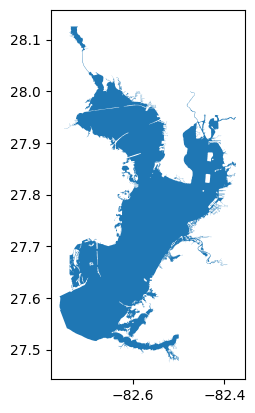

In [3]:
# Read geometry for Area of Interest from geojson file url and plot
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# geoJSON should be WGS1984 standard, but this one isn't
aoi_gdf = wrangle.as_gdf(aoi_url).to_crs(epsg=4326)
aoi_gdf.plot()

In [4]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] =wrangle.get_bounding_box(aoi_gdf)

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:210: DtypeWarning: Columns (8,10,14,21,27,29,30,33,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [6]:
# Rows and columns for results
stations.shape

(16500, 37)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 27.520872
LongitudeMeasure                                -82.40176
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:356: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  cond_notna = mask & (df_out["QA_flag"].notna())  # Mask cond and not NA
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version

In [10]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(16500, 42)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                 4269.0
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at the different QA_flag flags that have been assigned,
# e.g., for bad datums or limited decimal precision
set(stations_gdf.loc[stations_gdf['QA_flag'].notna()]['QA_flag'])

{'HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed',
 'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed',
 'LatitudeMeasure: Imprecise: lessthan3decimaldigits; LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits',
 'LongitudeMeasure: Imprecise: lessthan3decimaldigits; HorizontalCoordinateReferenceSystemDatumName: Bad datum OTHER, EPSG:4326 assumed'}

<Axes: >

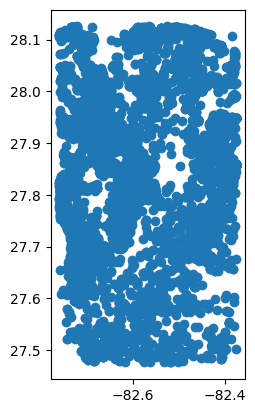

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<Axes: >

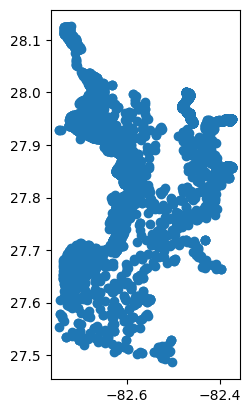

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

10922

In [19]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/dataretrieval/wqp.py:153: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,33,36,38,56,57,58,60,61,62,63,64,65,70,71,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(StringIO(response.text), delimiter=",")


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-131216112-M,2013-12-16,12:01:00,EST,21FLHILL_WQX-112,STORET-301229196,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531360,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979311F-1979-0,1979-10-31,00:00:00,EST,21FLBSG-13,STORET-100013954247.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1531361,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979174-1979-0,1979-09-17,00:00:00,EST,21FLBSG-13,STORET-100013931237.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1531362,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979192F-1979-0,1979-11-19,00:00:00,EST,21FLBSG-13,STORET-100014001269.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1531363,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979170-1979-0,1979-10-17,00:00:00,EST,21FLBSG-13,STORET-100013991881.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


<Axes: >

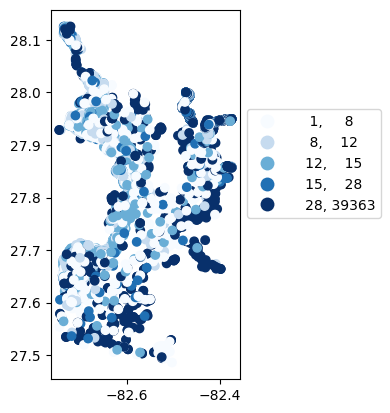

In [22]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
legend_kwds = {"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)}
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize?

##### secchi disk depth

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/clean.py:360: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'ResultMeasureValue: "Not Reported" result cannot be used' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask & (df_out["QA_flag"].isna()), "QA_flag"] = flag


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.8, 'meter')> <Quantity(2.2, 'meter')>
 <Quantity(2.7, 'meter')> ... <Quantity(1.4, 'meter')>
 <Quantity(1.3, 'meter')> <Quantity(1.3, 'meter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    92214.000000
mean         1.475033
std          0.909222
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 281
Usable results with inferred units: 1
Results outside threshold (0.0 to 6.930366743684113): 55


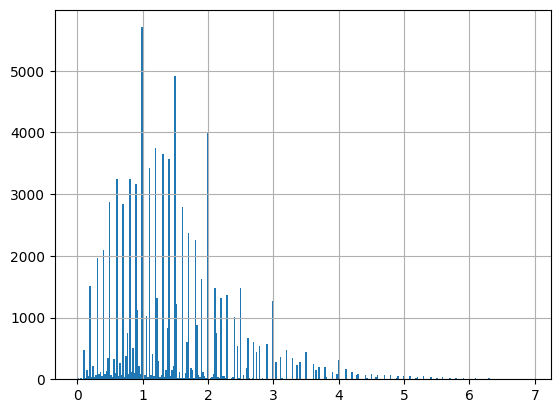

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
36,21FLHILL_WQX-1510,0.80,m,NaN,m,0.8 meter
68,21FLMANA_WQX-428,2.2,m,NaN,m,2.2 meter
96,21FLHILL_WQX-096,2.70,m,NaN,m,2.7 meter
106,21FLHILL_WQX-064,0.80,m,NaN,m,0.8 meter
127,21FLCOSP_WQX-COSPE6-2,1.7,m,NaN,m,1.7 meter
...,...,...,...,...,...,...
1531274,21FLBSG-13,0.8,m,NaN,m,0.8 meter
1531275,21FLBSG-13,1.2,m,NaN,m,1.2 meter
1531276,21FLBSG-13,1.4,m,NaN,m,1.4 meter
1531295,21FLBSG-13,1.3,m,NaN,m,1.3 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
567089,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
571986,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
575297,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
577222,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
578701,21FLPDEM_WQX-E2-D-19-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1511273,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1518530,21FLHILL_WQX-1615,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1518995,21FLHILL_WQX-1614,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1521334,21FLHILL_WQX-1616,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
284818,NARS_WQX-NCCA10-1674,-9,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",m,-9.0 meter
567089,21FLPDEM_WQX-14-02,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
571986,21FLKWAT_WQX-HIL-RAINBOW-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
575297,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-8,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
577222,21FLKWAT_WQX-PIN-COFFEEPOBAYOU-6,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...,...
1511273,USGS-275530082383300,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1518530,21FLHILL_WQX-1615,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1518995,21FLHILL_WQX-1614,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
1521334,21FLHILL_WQX-1616,Not Reported,m,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


If both value and unit are missing nothing can be done, a unitless (NaN) value is assumed as to be in default units but a QA_flag is added

In [29]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
12140,USGS-280630082350900,3,1.966667
12141,USGS-280635082322100,2,2.100000
12142,USGS-280640082434700,3,2.302933
12143,USGS-280719082291400,2,1.000000


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 2.
  self.bins = quantile(y, k=k)


<Axes: >

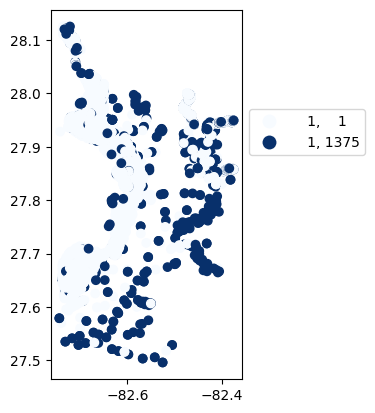

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

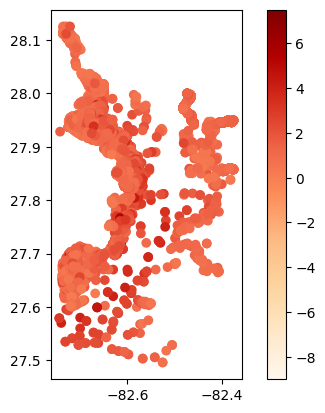

In [31]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(28.19, 'degree_Celsius')> <Quantity(29.52, 'degree_Celsius')>
 <Quantity(21.0, 'degree_Celsius')> ... <Quantity(25.9, 'degree_Celsius')>
 <Quantity(25.7, 'degree_Celsius')> <Quantity(19.8, 'degree_Celsius')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    311615.000000
mean         25.283109
std          78.407752
min          -2.900000
25%          21.200000
50%          25.860000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 174
Usable results with inferred units: 0
Results outside threshold (0.0 to 495.72962089666254): 2


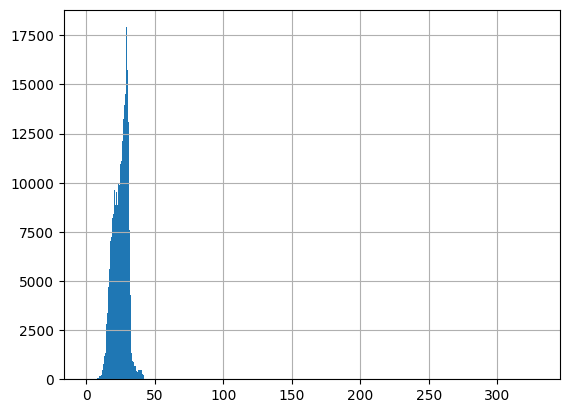

In [32]:
#'Temperature, water'
# Note: Default errors='raise'
df = harmonize.harmonize(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLHILL_WQX-047,28.19,deg C,NaN,28.19 degree_Celsius,degC
9,21FLTBW_WQX-M23,29.52,deg C,NaN,29.52 degree_Celsius,degC
14,21FLMANA_WQX-GA1,21,deg C,NaN,21.0 degree_Celsius,degC
34,21FLHILL_WQX-1509,27.67,deg C,NaN,27.67 degree_Celsius,degC
37,21FLTBW_WQX-PR103026,17.73,deg C,NaN,17.73 degree_Celsius,degC
...,...,...,...,...,...,...
1531340,21FLBSG-13,28.3,deg C,NaN,28.3 degree_Celsius,degC
1531341,21FLBSG-13,16.8,deg C,NaN,16.8 degree_Celsius,degC
1531342,21FLBSG-13,25.9,deg C,NaN,25.9 degree_Celsius,degC
1531343,21FLBSG-13,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
571226,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
572314,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
573747,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
578785,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
584872,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
893017,21FLPDEM_WQX-35-01,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
896718,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1402157,USGS-280228082343000,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1504618,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
571226,21FLPDEM_WQX-19-13,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
572314,21FLPDEM_WQX-24-07,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
573747,21FLPDEM_WQX-12-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
578785,21FLPDEM_WQX-23-08,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
584872,21FLPDEM_WQX-04-04,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...,...
1443491,21FLPDEM_WQX-12-02,Not Reported,deg C,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1462126,21FLPDEM_WQX-24-01,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1462575,21FLPDEM_WQX-04-04,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
1504618,USGS-02306028,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [37]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
15295,USGS-280726082313300,4,28.025000
15296,USGS-280728082301101,54,25.083333
15297,USGS-280729082313501,1,27.400000
15298,USGS-280730082313201,1,24.700000


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

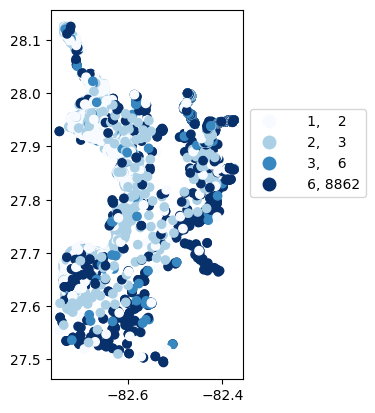

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

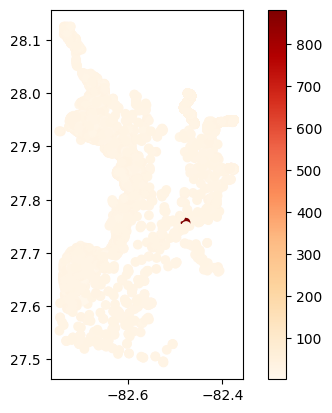

In [39]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize(df, 'Dissolved oxygen (DO)')

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(9.32, 'milligram / liter')>
 <Quantity(8.08, 'milligram / liter')>
 <Quantity(4.9, 'milligram / liter')> ...
 <Quantity(8.2, 'milligram / liter')> <Quantity(7.9, 'milligram / liter')>
 <Quantity(10.4, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1529429,21FLBSG-13,8.3,mg/l,NaN,8.3 milligram / liter
1529430,21FLBSG-13,12.4,mg/l,NaN,12.4 milligram / liter
1529431,21FLBSG-13,8.2,mg/l,NaN,8.2 milligram / liter
1529432,21FLBSG-13,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
0,21FLHILL_WQX-585,9.32,mg/L,NaN,9.32 milligram / liter
10,21FLHILL_WQX-1606,8.08,mg/L,NaN,8.08 milligram / liter
12,21FLHILL_WQX-1611,4.90,mg/L,NaN,4.9 milligram / liter
16,21FLHILL_WQX-1606,2.56,mg/L,NaN,2.56 milligram / liter
19,21FLPDEM_WQX-24-01,68.7,%,NaN,0.05676222371166 milligram / liter
...,...,...,...,...,...
1527283,21FLHILL_WQX-1510,0.13,mg/L,NaN,0.13 milligram / liter
1527285,21FLHILL_WQX-47,5.9,mg/L,NaN,5.9 milligram / liter
1527296,21FLHILL_WQX-120,1.75,mg/L,NaN,1.75 milligram / liter
1527311,21FLHILL_WQX-144,2.14,mg/L,NaN,2.14 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
13868,NARS_WQX-NCCA10-1672,8,5.437500
13869,NARS_WQX-NCCA10-1673,20,4.115000
13870,NARS_WQX-NCCA10-1674,6,2.466667
13871,NARS_WQX-NLA06608-0161,5,6.500000


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/mapclassify/classifiers.py:1653: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


<Axes: >

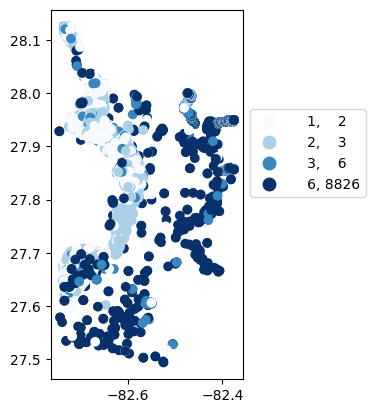

In [44]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds=legend_kwds)

<Axes: >

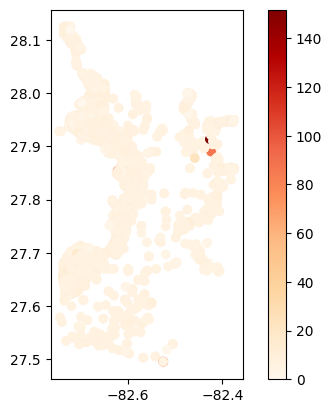

In [45]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(7.48, 'dimensionless')> <Quantity(8.18, 'dimensionless')>
 <Quantity(7.81, 'dimensionless')> ... <Quantity(7.8, 'dimensionless')>
 <Quantity(7.7, 'dimensionless')> <Quantity(7.6, 'dimensionless')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    287940.000000
mean          7.761439
std           0.471780
min           0.370000
25%           7.520000
50%           7.890000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 194
Usable results with inferred units: 269421
Results outside threshold (0.0 to 10.59211708420855): 7


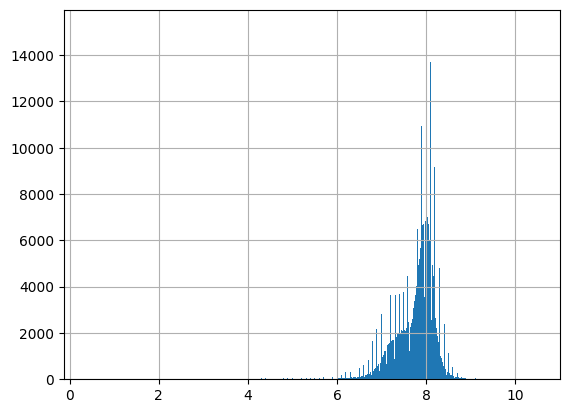

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
4,7.48,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.48 dimensionless
5,8.18,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",8.18 dimensionless
7,7.81,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.81 dimensionless
11,7.96,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.96 dimensionless
17,7.92,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",7.92 dimensionless
...,...,...,...,...
1530072,7.9,std units,NaN,7.9 dimensionless
1530073,7.3,std units,NaN,7.3 dimensionless
1530075,7.8,std units,NaN,7.8 dimensionless
1530076,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '@25C' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:510: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.df[c_mask] = basis.update_result_basis(


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(40.0, 'Practical_Salinity_Units')>
 <Quantity(29.0, 'Practical_Salinity_Units')>
 <Quantity(26.04, 'Practical_Salinity_Units')> ...
 <Quantity(22.0, 'Practical_Salinity_Units')>
 <Quantity(21.9, 'Practical_Salinity_Units')>
 <Quantity(22.7, 'Practical_Salinity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    278658.000000
mean         21.642689
std          93.397885
min          -0.020000
25%          17.850000
50%          24.900000
75%          28.680000
max       48930.000000
dtype: float64
Unusable results: 1275
Usable results with inferred units: 0
Results outside threshold (0.0 to 582.029999091121): 4


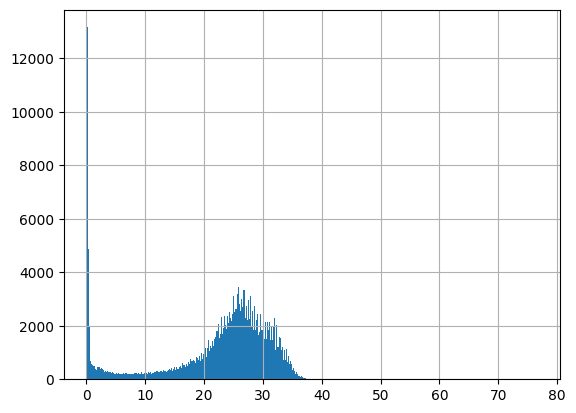

In [48]:
# Salinity
df = harmonize.harmonize(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
1,40,ppth,NaN,40.0 Practical_Salinity_Units
6,29,PSS,NaN,29.0 Practical_Salinity_Units
8,26.04,PSS,NaN,26.04 Practical_Salinity_Units
21,0.18,ppth,NaN,0.18 Practical_Salinity_Units
23,5.9,ppth,NaN,5.9 Practical_Salinity_Units
...,...,...,...,...
1531330,15.9,PSS,NaN,15.9 Practical_Salinity_Units
1531359,23,PSS,NaN,23.0 Practical_Salinity_Units
1531360,22,PSS,NaN,22.0 Practical_Salinity_Units
1531362,21.9,PSS,NaN,21.9 Practical_Salinity_Units


##### Nitrogen

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/basis.py:343: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'as N' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[mask, basis_col] = basis


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:484: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' 'as N' nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 'as N'
 nan nan nan 'as N' nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan 'as N' nan 'as N' nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan 'as N' nan nan nan nan
 'as N' nan 'as N' 'as N' nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly 

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.39, 'milligram / liter')>
 <Quantity(0.4475, 'milligram / liter')>
 <Quantity(0.425, 'milligram / liter')>
 <Quantity(0.4625, 'milligram / liter')>
 <Quantity(0.33625, 'milligram / liter')>
 <Quantity(0.28, 'milligram / liter')>
 <Quantity(0.5625, 'milligram / liter')>
 <Quantity(0.21875, 'milligram / liter')>
 <Quantity(0.629, 'milligram / liter')>
 <Quantity(0.505, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.325, 'milligram / liter')>
 <Quantity(0.253, 'milligram / liter')>
 <Quantity(0.456, 'milligram / liter')>
 <Quantity(0.183, 'milligram / liter')>
 <Quantity(0.526, 'milligram / liter')>
 <Quantity(0.264, 'milligram / liter')>
 <Quantity(0.188, 'milligram / liter')>
 <Quantity(0.346, 'milligram / liter')>
 <Quantity

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sub_df[cols[2]] = sub_df[cols[2]].fillna(sub_df[cols[1]])  # new_fract
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/domains.py:277: FutureWarning: Downcasting object dtyp

-Usable results-
count    163.000000
mean       1.575389
std        4.532429
min        0.024000
25%        0.202720
50%        0.315560
75%        0.500170
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.769965070579055): 0


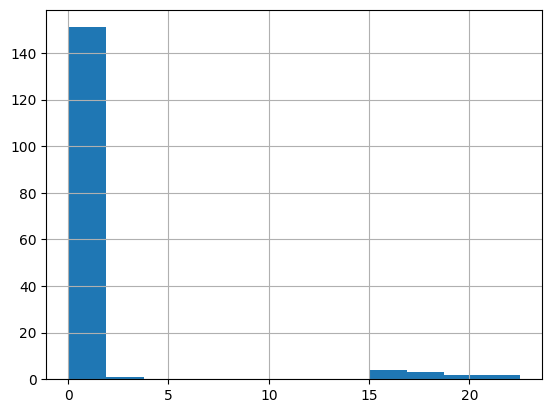

In [50]:
# Nitrogen
df = harmonize.harmonize(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
262029,0.39,mg/L,NaN,0.39 milligram / liter
278162,0.4475,mg/L,NaN,0.4475 milligram / liter
280955,0.425,mg/L,NaN,0.425 milligram / liter
294787,0.4625,mg/L,NaN,0.4625 milligram / liter
296176,0.33625,mg/L,NaN,0.33625 milligram / liter
...,...,...,...,...
1529443,0.084,mg/l,NaN,0.084 milligram / liter
1529451,0.166,mg/l,NaN,0.166 milligram / liter
1529461,0.091,mg/l,NaN,0.091 milligram / liter
1529495,0.057,mg/l,NaN,0.057 milligram / liter


##### Conductivity

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(626.0, 'microsiemens / centimeter')>
 <Quantity(688.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(606.0, 'microsiemens / centimeter')>
 <Quantity(633.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(776.0, 'microsiemens / centimeter')>
 <Quantity(775.0, 'microsiemens / centimeter')>
 <Quantity(20500.0, 'microsiemens / centimeter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count       11.000000
mean      2503.363636
std       5969.279978
min        606.000000
25%        629.500000
50%        775.000000
75%        776.000000
max      20500.000000
dtype: float64
Unusable results: 8
Usable results with inferred units: 0
Results outside threshold (0.0 to 38319.04350375742): 0


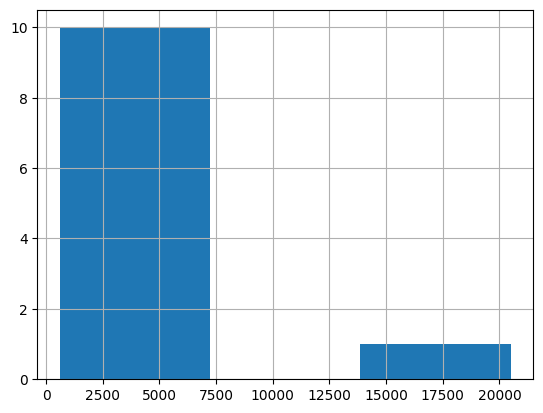

In [52]:
# Conductivity
df = harmonize.harmonize(df, 'Conductivity', report=True)

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
326137,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
330828,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
332265,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
334703,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
335567,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
337357,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
342039,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
358182,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
369692,626,uS/cm,NaN,626.0 microsiemens / centimeter
374058,688,uS/cm,NaN,688.0 microsiemens / centimeter


##### Chlorophyll a

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.00594, 'milligram / liter')>
 <Quantity(0.00145, 'milligram / liter')>
 <Quantity(0.00277, 'milligram / liter')> ...
 <Quantity(0.03108, 'milligram / liter')>
 <Quantity(0.04822, 'milligram / liter')>
 <Quantity(0.06407, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    43334.000000
mean         0.014368
std          0.022741
min         -0.000506
25%          0.004600
50%          0.008725
75%          0.016360
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.1508140878070869): 197


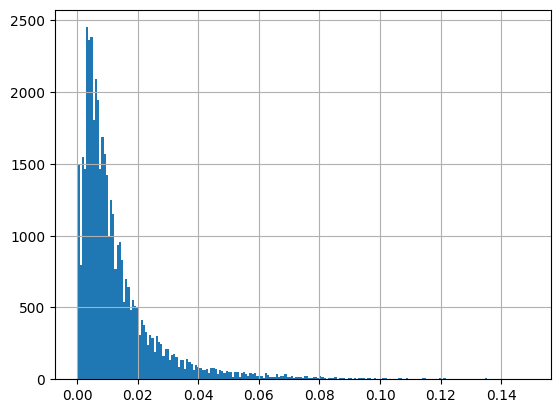

In [54]:
# Chlorophyll a
df = harmonize.harmonize(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
261544,5.94,ug/L,NaN,0.005940000000000001 milligram / liter
266516,1.45,ug/L,NaN,0.00145 milligram / liter
267451,2.77,ug/L,NaN,0.00277 milligram / liter
268302,3.87,ug/L,NaN,0.00387 milligram / liter
276393,8.15,ug/L,NaN,0.008150000000000001 milligram / liter
...,...,...,...,...
1531355,41.36,ug/l,NaN,0.04136 milligram / liter
1531357,28.33,ug/l,NaN,0.028329999999999998 milligram / liter
1531358,31.08,ug/l,NaN,0.03108 milligram / liter
1531361,48.22,ug/l,NaN,0.04822 milligram / liter


##### Organic Carbon

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(3.8, 'milligram / liter')>
 <Quantity(19.5, 'milligram / liter')>
 <Quantity(11.3, 'milligram / liter')> ...
 <Quantity(4.8, 'milligram / liter')>
 <Quantity(12.9, 'milligram / liter')>
 <Quantity(3.7, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    2.391300e+04
mean     2.221468e+04
std      1.809492e+06
min      0.000000e+00
25%      4.500000e+00
50%      7.000000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1956
Usable results with inferred units: 0
Results outside threshold (0.0 to 10879164.83130325): 8


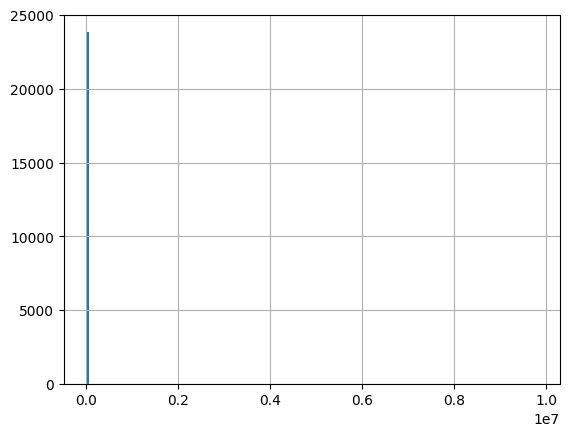

In [56]:
# Organic carbon (%)
df = harmonize.harmonize(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/L,NaN,3.8 milligram / liter
124,19.5,mg/L,NaN,19.5 milligram / liter
125,11.3,mg/L,NaN,11.3 milligram / liter
129,6.7,mg/L,NaN,6.7 milligram / liter
135,28.0,mg/L,NaN,28.0 milligram / liter
...,...,...,...,...
1527677,4.53,mg/l,NaN,4.53 milligram / liter
1527682,1.56,mg/l,NaN,1.56 milligram / liter
1527687,4.80,mg/l,NaN,4.8 milligram / liter
1527692,12.9,mg/l,NaN,12.9 milligram / liter


##### Turbidity (NTU)

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(4.49, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.2, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.9, 'Nephelometric_Turbidity_Units')> ...
 <Quantity(0.7, 'Nephelometric_Turbidity_Units')>
 <Quantity(2.3, 'Nephelometric_Turbidity_Units')>
 <Quantity(1.1, 'Nephelometric_Turbidity_Units')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count     96589.000000
mean         15.643710
std         852.583366
min          -0.047700
25%           1.500000
50%           2.500000
75%           4.100000
max      200000.000000
dtype: float64
Unusable results: 1149
Usable results with inferred units: 0
Results outside threshold (0.0 to 5131.1439034733785): 157


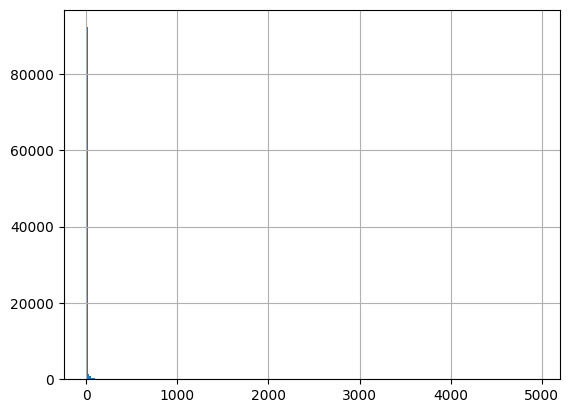

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
25,4.49,NTU,NaN,4.49 Nephelometric_Turbidity_Units
81,1.2,NTU,NaN,1.2 Nephelometric_Turbidity_Units
108,2.9,NTU,NaN,2.9 Nephelometric_Turbidity_Units
147,6.9,NTU,NaN,6.9 Nephelometric_Turbidity_Units
222,4.3,NTU,NaN,4.3 Nephelometric_Turbidity_Units
...,...,...,...,...
1527750,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1527960,0.9,NTRU,NaN,0.9 Nephelometric_Turbidity_Units
1528039,0.7,NTRU,NaN,0.7 Nephelometric_Turbidity_Units
1528079,2.3,NTRU,NaN,2.3 Nephelometric_Turbidity_Units


##### Sediment

In [60]:
# Sediment
df = harmonize.harmonize(df, 'Sediment', report=False)

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
df = harmonize.harmonize(df, 'Phosphorus')

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[<Quantity(0.049, 'milligram / liter')>
 <Quantity(0.004, 'milligram / liter')>
 <Quantity(0.049, 'milligram / liter')> ...
 <Quantity(0.04, 'milligram / liter')>
 <Quantity(0.05, 'milligram / liter')>
 <Quantity(0.04, 'milligram / liter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


2 Phosphorus sample fractions not in frac_dict


2 Phosphorus sample fractions not in frac_dict found in expected domains, mapped to "Other_Phosphorus"


Note: warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# All Phosphorus
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']
df.loc[df['Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
19612,0.050,mg/L,NaN,0.05 milligram / liter
...,...,...,...,...
1529740,0.065,mg/l as P,NaN,NaN
1529745,0.027,mg/l as P,NaN,NaN
1529751,0.04,mg/l as P,NaN,NaN
1529766,0.05,mg/l as P,NaN,NaN


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
3156,0.049,mg/L,NaN,NaN
7402,0.004,mg/L,NaN,NaN
9350,0.049,mg/L,NaN,NaN
11185,0.036,mg/L,NaN,NaN
23731,0.004,mg/L,NaN,NaN
...,...,...,...,...
1529740,0.065,mg/l as P,NaN,NaN
1529745,0.027,mg/l as P,NaN,NaN
1529751,0.04,mg/l as P,NaN,NaN
1529766,0.05,mg/l as P,NaN,NaN


In [65]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
19612,0.050,mg/L,NaN,0.05 milligram / liter
29925,0.009,mg/L,NaN,0.009 milligram / liter
56000,0.003,mg/L,NaN,0.003 milligram / liter
65845,0.050,mg/L,NaN,0.05 milligram / liter
70783,0.002,mg/L,NaN,0.002 milligram / liter
...,...,...,...,...
1513660,0.35,mg/l as P,NaN,0.35 milligram / liter
1513663,0.2,mg/l as P,NaN,0.2 milligram / liter
1513668,0.22,mg/l as P,NaN,0.22 milligram / liter
1513691,0.18,mg/l as P,NaN,0.18 milligram / liter


In [66]:
# All other phosphorus sample fractions
df.loc[df['Other_Phosphorus'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
262349,0.13118375,mg/L,NaN,NaN
279116,0.1696225,mg/L,NaN,NaN
279554,0.0835825,mg/L,NaN,NaN
285845,0.16950375,mg/L,NaN,NaN
295477,0.03524375,mg/L,NaN,NaN
...,...,...,...,...
1508841,420.0,mg/kg as P,NaN,NaN
1509181,0.38,%,NaN,NaN
1509190,330.0,mg/kg as P,NaN,NaN
1524800,460,mg/kg,NaN,NaN


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan
 <Quantity(2.0, 'Colony_Forming_Units / milliliter')>]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count    8.647000e+03
mean     4.903257e+03
std      1.318438e+05
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      6.000000e+01
max      1.000000e+07
dtype: float64
Unusable results: 57142
Usable results with inferred units: 5
Results outside threshold (0.0 to 795966.1242988213): 8


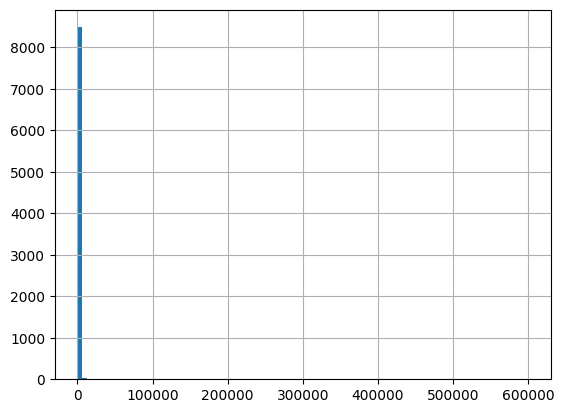

In [67]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Fecal Coliform', report=True, errors='ignore')

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
13,760,cfu/100mL,NaN,NaN
15,2900,cfu/100mL,NaN,NaN
55,300,#/100mL,NaN,NaN
72,280,#/100mL,NaN,NaN
109,52,cfu/100mL,NaN,NaN
...,...,...,...,...
1527154,20,cfu/100mL,NaN,NaN
1527196,2,cfu/100mL,NaN,NaN
1527214,2,cfu/100mL,NaN,NaN
1527262,2,cfu/100mL,NaN,NaN


###### Excherichia Coli

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:158: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for bad_meas in pandas.unique(bad_measures):


/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'CFU/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'MPN/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/convert.py:128: UserWarning: WARNING: 'cfu/100mL' converted to NaN
  warn(f"WARNING: '{unit}' converted to NaN")
/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wq_data.py:663: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_out.loc[m_mask, self.out_col] = convert_unit_series(**params)


-Usable results-
count      142.000000
mean       976.669014
std       4473.446618
min          0.000000
25%         21.000000
50%         46.000000
75%        120.000000
max      41000.000000
dtype: float64
Unusable results: 7523
Usable results with inferred units: 0
Results outside threshold (0.0 to 27817.348725062726): 1


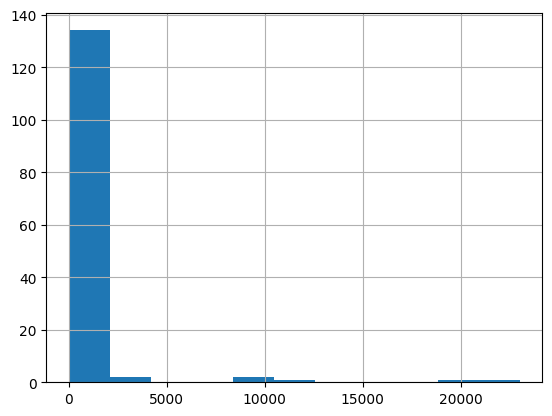

In [69]:
# Known unit with bad dimensionality ('Colony_Forming_Units * milliliter')
df = harmonize.harmonize(df, 'Escherichia coli', report=True, errors='ignore')

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
218670,210,MPN/100mL,NaN,NaN
220218,4800,MPN/100mL,NaN,NaN
220471,74.5,MPN/100mL,NaN,NaN
220737,553.9,MPN/100mL,NaN,NaN
221299,87,MPN/100mL,NaN,NaN
...,...,...,...,...
1527062,308,MPN/100mL,NaN,NaN
1527080,1933,cfu/100mL,NaN,NaN
1527237,1367,cfu/100mL,NaN,NaN
1527264,420,cfu/100mL,NaN,NaN


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

Explore Salinity results:

In [71]:
from harmonize_wq import convert

In [72]:
# Salinity summary statistics
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 278658 
Mean: 21.64268859718502 PSU


In [73]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

Other fields like units and QA_flag may help understand what caused high values and what results might need to be dropped from consideration

In [74]:
# Columns to focus on
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']

In [75]:
# Look at important fields for max 5 values
salinity_series = df['Salinity'][df['Salinity'].notna()]
salinity_series.sort_values(ascending=False, inplace=True)
df[cols][df['Salinity'].isin(salinity_series[0:5])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
231008,48930,ppth,NaN,48930.0 Practical_Salinity_Units
387447,54.8,ppth,NaN,54.8 Practical_Salinity_Units
473519,76.57,ppth,NaN,76.57 Practical_Salinity_Units
775905,2976,ppth,NaN,2976.0 Practical_Salinity_Units
797366,68.0,ppth,NaN,68.0 Practical_Salinity_Units


Detection limits may help understand what caused low values and what results might need to be dropped or updated

In [76]:
df = wrangle.add_detection(df, 'Salinity')
cols+=['ResultDetectionConditionText',
       'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode']

/opt/hostedtoolcache/Python/3.9.24/x64/lib/python3.9/site-packages/harmonize_wq/wrangle.py:501: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  detection_df = pandas.concat(detection_list).drop_duplicates()


In [77]:
# Look at important fields for min 5 values (often multiple 0.0)
df[cols][df['Salinity'].isin(salinity_series[-5:])]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,ResultDetectionConditionText,DetectionQuantitationLimitTypeName,DetectionQuantitationLimitMeasure/MeasureValue,DetectionQuantitationLimitMeasure/MeasureUnitCode
25645,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
25646,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
46162,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Lower Quantitation Limit,5.0,ppth
46163,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,Method Detection Level,1.0,ppth
456971,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
542723,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
563840,0.0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
661715,-0.02,ppth,NaN,-0.02 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1055106,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN
1057937,0,ppth,NaN,0.0 Practical_Salinity_Units,NaN,NaN,NaN,NaN


Explore Conductivity results:

In [78]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

371418      626.0 microsiemens / centimeter
375809      688.0 microsiemens / centimeter
393319      606.0 microsiemens / centimeter
394441      606.0 microsiemens / centimeter
397689      633.0 microsiemens / centimeter
695861      776.0 microsiemens / centimeter
698616      776.0 microsiemens / centimeter
699548      775.0 microsiemens / centimeter
701638      776.0 microsiemens / centimeter
704845      775.0 microsiemens / centimeter
878304    20500.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm, use a higher threshold for coastal waters

In [79]:
# Sort and check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.sort_values(by=['Conductivity'], ascending=False, inplace=True)
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
878304,20500,uS/cm,NaN,NaN,20500.0 microsiemens / centimeter
695861,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
698616,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
701638,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
699548,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
704845,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
375809,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
397689,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
371418,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter
393319,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter


In [80]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

878304    12.242 dimensionless
695861     0.379 dimensionless
698616     0.379 dimensionless
701638     0.379 dimensionless
699548     0.379 dimensionless
704845     0.379 dimensionless
375809     0.335 dimensionless
397689     0.308 dimensionless
371418     0.304 dimensionless
393319     0.294 dimensionless
394441     0.294 dimensionless
Name: Salinity, dtype: object

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [81]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
878304,2021-09-17,NaN,NaN
695861,2007-08-15,NaN,NaN
698616,2007-08-15,NaN,NaN
701638,2007-08-15,NaN,NaN
699548,2007-08-15,NaN,NaN
...,...,...,...
1535004,1979-10-31,00:00:00,EST
1535005,1979-09-17,00:00:00,EST
1535006,1979-11-19,00:00:00,EST
1535007,1979-10-17,00:00:00,EST


In [82]:
# 'ActivityStartDate' presserves date where 'Activity_datetime' is NAT due to no time zone
df = clean.datetime(df)
df[['ActivityStartDate', 'Activity_datetime']]

,ActivityStartDate,Activity_datetime
878304,2021-09-17,NaT
695861,2007-08-15,NaT
698616,2007-08-15,NaT
701638,2007-08-15,NaT
699548,2007-08-15,NaT
...,...,...
1535004,1979-10-31,1979-10-31 05:00:00+00:00
1535005,1979-09-17,1979-09-17 05:00:00+00:00
1535006,1979-11-19,1979-11-19 05:00:00+00:00
1535007,1979-10-17,1979-10-17 05:00:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a ActivityStartDate column is used to preserve date only.

#### Depth

Note: Data are often lacking sample depth metadata

In [83]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

375809     0.95
397689     0.50
371418     0.00
318451     0.10
319046     0.10
           ... 
1382127    0.33
1459451    0.30
1462963    0.33
1464578    0.33
1464644    0.30
Name: ResultDepthHeightMeasure/MeasureValue, Length: 505, dtype: float64

#### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Secchi,QA_Nitrogen,QA_Conductivity,QA_Fecal_Coliform,QA_Turbidity,QA_E_coli,QA_Salinity
878304,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,2021-09-17,NaN,NaN,NARS_WQX-NWC_FL-10535,STORET-1040690254,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695861,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698616,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145215,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701638,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145209,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699548,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,2007-08-15,NaN,NaN,NARS_WQX-NLA06608-0161,STORET-1055145207,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535004,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979311F-1979-0,1979-10-31,00:00:00,EST,21FLBSG-13,STORET-100013954247.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535005,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979174-1979-0,1979-09-17,00:00:00,EST,21FLBSG-13,STORET-100013931237.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535006,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979192F-1979-0,1979-11-19,00:00:00,EST,21FLBSG-13,STORET-100014001269.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1535007,21FLBSG,City of Tampa Bay Study Group (Florida),21FLBSG-1979170-1979-0,1979-10-17,00:00:00,EST,21FLBSG-13,STORET-100013991881.0000000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

14 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

71975 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'TOTAL NITROGEN_ MIXED FORMS', 'Conductivity',
       'Chlorophyll', 'Carbon', 'Turbidity', 'Sediment', 'Phosphorus',
       'TP_Phosphorus', 'TDP_Phosphorus', 'Other_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'DetectionQuantitationLimitTypeName',
       'DetectionQuantitationLimitMeasure/MeasureValue',
       'DetectionQuantitationLimitMeasure/MeasureUnitCode',
       'Activity_datetime', 'Depth', 'QA_pH', 'QA_Temperature',
       'QA_Chlorophyll', 'QA_DO', 'QA_Carbon', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus', 'QA_Secchi', 'QA_Nitrogen',
       'QA_Conductivity', 'QA_Fecal_Coliform', 'QA_Turbidity', 'QA_E_coli',
       'QA_Salinity'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Secchi,QA_Nitrogen,QA_Conductivity,QA_Fecal_Coliform,QA_Turbidity,QA_E_coli,QA_Salinity
878304,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-192970_2021,NARS_WQX-NWC_FL-10535,STORET,NaN,NaN,NaN,NaN,12.242 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695861,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3.3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
698616,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:3,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701638,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:2,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699548,NARS_WQX,EPA National Aquatic Resources Survey (NARS),NARS_WQX-PRF:0161:1:070815:1,NARS_WQX-NLA06608-0161,STORET,NaN,NaN,NaN,NaN,0.379 dimensionless,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Temperature',
 'QA_DO',
 'QA_Carbon',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Nitrogen',
 'QA_Conductivity',
 'QA_Turbidity',
 'QA_E_coli',
 'QA_Salinity']

<Axes: >

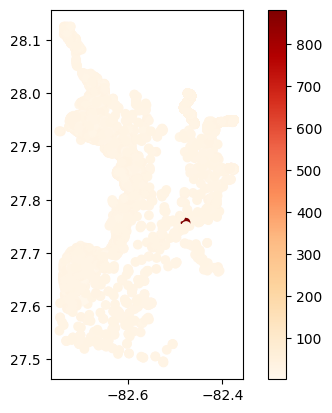

In [92]:
# Map average temperature at each station
results_gdf = visualize.map_measure(main_df, stations_clipped, 'Temperature')
results_gdf.plot(column='mean', cmap='OrRd', legend=True)